# Домашнее задание

ML разработчикам необходимо не только уметь обучать нейронные сети и генерировать новые идеи, но еще и уметь в страивать наработки в pipeline. В этом домашнем задании нам предстоит сделать из frustum детектора production ready (ну почти) решение, которое может работать на сырых данных.

К сожалению, frustum-pointnet работает независимо для каждой 2D детекции. В этом домашнем задании вам предстоит написать обертку над frustum-pointnet, которая будет работать над целыми облаками. Вам также нужно будет воспользоваться 2D детектором, чтобы находить коробки на изображении.

Во второй части задания вам нужно будет написать оценку качества работы вашего алгоритма, которая становится чуть сложнее, когда на сцене могут находится много объектов.

## Часть 1

Ниже написан класс, который вам нужно реализовать. Чтобы воспользоваться предобученной сетью, позаимствуйте код из
https://github.com/charlesq34/frustum-pointnets/blob/master/train/test.py

Предобученные модели лежат здесь: https://shapenet.cs.stanford.edu/media/frustum_pointnets_snapshots.zip

В частности, вам нужно модифицировать функцию `get_session_and_ops` - функция должна уметь работать без глобальных флагов. После этого посмотрите, как эта функция используется.
Выход сети преобразуется в понятный формат в функции `write_detection_results`.

In [1]:
! pip install "tensorflow==1.14"

  Using cached tensorflow-1.14.0-cp37-cp37m-macosx_10_11_x86_64.whl (105.8 MB)
  Using cached tensorboard-1.14.0-py3-none-any.whl (3.1 MB)
  Using cached tensorflow_estimator-1.14.0-py2.py3-none-any.whl (488 kB)
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your

In [1]:
import tensorflow as tf

/Users/vanna/miniconda3/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/vanna/miniconda3/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/vanna/miniconda3/envs/python37/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/vanna/miniconda3/envs/python37

In [516]:
from frustum_pointnets.models.frustum_pointnets_v1 import get_model
from frustum_pointnets.models.model_util import placeholder_inputs, get_loss
from frustum_pointnets.train.provider import from_prediction_to_label_format, rotate_pc_along_y
from frustum_pointnets.kitti.kitti_util import Calibration
from ssd import SSD

In [406]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [111]:
def softmax(x):
    ''' Numpy function for softmax'''
    shape = x.shape
    probs = np.exp(x - np.max(x, axis=len(shape)-1, keepdims=True))
    probs /= np.sum(probs, axis=len(shape)-1, keepdims=True)
    return probs

In [504]:
def car_to_cam(path):
    calib = Calibration(path)
    with open(path, 'r') as file:
        data = [f.rstrip() for f in file.readlines()][:-1]
        R0_rect = np.array(list(map(float, data[4].split()[1:]))).reshape(3, 3)
        R0_rect = np.concatenate((R0_rect, np.array([0, 0, 0]).reshape(3, 1)), axis=1)
        R0_rect = np.concatenate((R0_rect, np.array([0, 0, 0, 1]).reshape(1, 4)), axis=0)
        
        P2 = np.array(list(map(float, data[2].split()[1:]))).reshape(3, 4)
        
        V2C = np.array(list(map(float, data[5].split()[1:]))).reshape(3, 4)
        V2C = np.concatenate((V2C, np.array([0, 0, 0, 1]).reshape(1, 4)), axis=0)
        
        return P2, R0_rect, V2C, calib

In [422]:
def in_box(box, points, x, add=False):
    result = (points[:,1] > box[0]) & (points[:,1] < box[2]) & \
             (points[:,0] > box[1]) & (points[:,0] < box[3])
    if add:
        result = result & x
    return result

In [464]:
def get_session_and_ops(batch_size, num_point):
    """ Define model graph, load model parameters,
    create session and return session handle and tensors
    """
    with tf.Graph().as_default():
        with tf.device('/gpu:0'):
            pointclouds_pl, one_hot_vec_pl, labels_pl, centers_pl, \
            heading_class_label_pl, heading_residual_label_pl, \
            size_class_label_pl, size_residual_label_pl = \
                placeholder_inputs(batch_size, num_point)
            is_training_pl = tf.placeholder(tf.bool, shape=())
            end_points = get_model(pointclouds_pl, one_hot_vec_pl,
                                         is_training_pl)
            loss = get_loss(labels_pl, centers_pl,
                                  heading_class_label_pl, heading_residual_label_pl,
                                  size_class_label_pl, size_residual_label_pl, end_points)
            saver = tf.train.Saver()

        # Create a session
        config = tf.ConfigProto()
        config.gpu_options.allow_growth = True
        config.allow_soft_placement = True
        sess = tf.Session(config=config)

        # Restore variables from disk.
        saver.restore(sess, './frustum_model/frustum_pointnets_snapshots/log_v1/model.ckpt')
        ops = {'pointclouds_pl': pointclouds_pl,
               'one_hot_vec_pl': one_hot_vec_pl,
               'labels_pl': labels_pl,
               'centers_pl': centers_pl,
               'heading_class_label_pl': heading_class_label_pl,
               'heading_residual_label_pl': heading_residual_label_pl,
               'size_class_label_pl': size_class_label_pl,
               'size_residual_label_pl': size_residual_label_pl,
               'is_training_pl': is_training_pl,
               'logits': end_points['mask_logits'],
               'center': end_points['center'],
               'end_points': end_points,
               'loss': loss}
        return sess, ops

In [465]:
class FrustumPointnet:
    def __init__(self, batch_size, num_points):
        self.batch_size = batch_size
        self.num_points = num_points
        self.sess, self.ops = get_session_and_ops(self.batch_size, self.num_points)
        
    def inference(self, pc, one_hot_vec):
        ''' Run inference for frustum pointnets in batch mode '''
        assert pc.shape[0] % self.batch_size == 0
        num_batches = int(pc.shape[0] / self.batch_size)
        logits = np.zeros((pc.shape[0], pc.shape[1], 2))
        centers = np.zeros((pc.shape[0], 3))
        heading_logits = np.zeros((pc.shape[0], 12))
        heading_residuals = np.zeros((pc.shape[0], 12))
        size_logits = np.zeros((pc.shape[0], 8))
        size_residuals = np.zeros((pc.shape[0], 8, 3))
        scores = np.zeros((pc.shape[0],))  # 3D box score

        ep = ops['end_points']
        for i in range(self.batch_size):
            feed_dict = { \
                ops['pointclouds_pl']: pc[i * self.batch_size:(i + 1) * self.batch_size, ...],
                ops['one_hot_vec_pl']: one_hot_vec[i * self.batch_size:(i + 1) * self.batch_size, :],
                ops['is_training_pl']: False}

            batch_logits, batch_centers, \
            batch_heading_scores, batch_heading_residuals, \
            batch_size_scores, batch_size_residuals = \
                sess.run([ops['logits'], ops['center'],
                          ep['heading_scores'], ep['heading_residuals'],
                          ep['size_scores'], ep['size_residuals']],
                         feed_dict=feed_dict)

            logits[i * self.batch_size:(i + 1) * self.batch_size, ...] = batch_logits
            centers[i * self.batch_size:(i + 1) * self.batch_size, ...] = batch_centers
            heading_logits[i * self.batch_size:(i + 1) * self.batch_size, ...] = batch_heading_scores
            heading_residuals[i * self.batch_size:(i + 1) * self.batch_size, ...] = batch_heading_residuals
            size_logits[i * self.batch_size:(i + 1) * self.batch_size, ...] = batch_size_scores
            size_residuals[i * self.batch_size:(i + 1) * self.batch_size, ...] = batch_size_residuals

        heading_cls = np.argmax(heading_logits, 1)  # B
        size_cls = np.argmax(size_logits, 1)  # B
        heading_res = np.array([heading_residuals[i, heading_cls[i]] \
                                for i in range(pc.shape[0])])
        size_res = np.vstack([size_residuals[i, size_cls[i], :] \
                              for i in range(pc.shape[0])])

        return np.argmax(logits, 2), centers, heading_cls, heading_res, \
               size_cls, size_res

In [545]:
from collections import namedtuple

Detection = namedtuple('Detection', ['xyz', 'angle', 'lwh', 'confidence'])
Scene = namedtuple('Scene', ['detections'])

class PipelineDetector(object):
    def __init__(self, frustum_pointnet, frustum_batch_size, ssd_detector, ssd_threshold):
        self.pointnet = frustum_pointnet
        self.batch_size = frustum_batch_size
        self.detector = ssd_detector
        self.threshold = ssd_threshold
    
    def predict(self, xyz, image, matrices, draw_plot=True):        
        batch = []
        one_hot_vec = []
        boxes = []
        in_ = []
        angles = []
        scores = []
        
        # TODO: run 2D detector on the image
        detection = self.detector.predict(image)
        
        # TODO: process lidar point cloud and construct frustum examples
        P2, R0_rect, V2C, calib = matrices
        
        xyz_ = xyz.copy()
        xyz_[:, 3] = 1
        rect = np.dot(xyz_, np.dot(R0_rect, V2C).T)
        
        points = np.dot(rect, P2.T)

        rect[:, 3] = xyz[:, 3]
        points = points[:, :2] / points[:, 2:]
        
        in_image = in_box((0, 0, image.shape[0], image.shape[1]), points, (xyz[:, 0] > 0.0), add=True)
        points = points[in_image]
        
        # TODO: extract bounding boxes with vehicle classes and filter them by ssd_threshold
        cond = (detection['detection_classes'] == 1) & (detection['detection_scores'] >= self.threshold)
        ids = np.where(cond)[0]
        
        for i in ids:
            box = detection['detection_boxes'][i].reshape(2, 2)
            box = (box * image.shape[:2]).astype(int)
            x_min, x_max, y_min, y_max = box[0][1], box[1][1], box[0][0], box[1][0]
            in_b = in_box((y_min, x_min, y_max, x_max), points, 0, add=False)
            points_in = rect[in_image][in_b]

            center = np.array([(x_min + x_max) / 2.0, (y_min + y_max) / 2.0])
            uvdepth = np.zeros((1, 3))
            uvdepth[0, 0:2] = center
            uvdepth[0, 2] = 20 
            center_rect = calib.project_image_to_rect(uvdepth)
            angle = np.pi / 2 - 1 * np.arctan2(center_rect[0, 2], center_rect[0, 0]) 
            angles.append(angle)
            
            points_in[:, :3] = rotate_pc_along_y(points_in[:, :3], angle)
            
            idxs = np.random.choice([x for x in range(points_in.shape[0])], size=self.pointnet.num_points)
            points_in = points_in[idxs, :]

            
            batch.append(points_in)
            one_hot_vec.append([1, 0, 0])
            boxes.append(box)
            in_.append(points[in_b])
            scores.append(detection['detection_scores'][i])
                
        if draw_plot:
            self.plot(image, boxes, in_)
        batch = np.array(batch)
        one_hot_vec = np.array(one_hot_vec)
        detections = []
        
        # TODO: run frustum inference (use batch to accelerate inference per frame)
        logits, centers, heading_cls, heading_res, \
        size_cls, size_res = self.pointnet.inference(batch, one_hot_vec)
        
        # TODO: construct Scene namedtuple and return it
        for i in range(len(batch)):
            h, w, l, tx, ty, tz, ry = from_prediction_to_label_format(centers[i], heading_cls[i], 
                                                                      heading_res[i], size_cls[i],
                                                                      size_res[i], angles[i])
            d = Detection(np.array([tx, ty, tz]), ry, np.array([l, w, h]), scores[i])
            detections.append(d)
        result = Scene(detections)
        return result
    
    def plot(self, image, boxes, points):
        plt.figure(figsize=(20, 10))
        plt.imshow(image)
        for box in boxes:
            box = box.reshape(2, 2)
            box = np.array([box[0], [box[0, 0], box[1, 1]], box[1], [box[1, 0], box[0, 1]], box[0]])
            plt.plot(box[:, 1], box[:, 0], c='y')
        for p in points:
            plt.scatter(p[:, 0], p[:, 1], s=1)
        return 

In [506]:
detector = SSD('tmp')
img = '000176'
image =  np.array(Image.open(f'training/image_2/{img}.png'))
matrix = car_to_cam(f'./training/calib/{img}.txt')
item = np.fromfile(f'training/velodyne/{img}.bin', dtype=np.float32).reshape(-1, 4)

In [507]:
frustum = FrustumPointnet(1, 1024)

INFO:tensorflow:Summary name 3d mask loss is illegal; using 3d_mask_loss instead.
INFO:tensorflow:Summary name center loss is illegal; using center_loss instead.
INFO:tensorflow:Summary name stage1 center loss is illegal; using stage1_center_loss instead.
INFO:tensorflow:Summary name heading class loss is illegal; using heading_class_loss instead.
INFO:tensorflow:Summary name heading residual normalized loss is illegal; using heading_residual_normalized_loss instead.
INFO:tensorflow:Summary name size class loss is illegal; using size_class_loss instead.
INFO:tensorflow:Summary name size residual normalized loss is illegal; using size_residual_normalized_loss instead.
INFO:tensorflow:Summary name corners loss is illegal; using corners_loss instead.
INFO:tensorflow:Restoring parameters from ./frustum_model/frustum_pointnets_snapshots/log_v1/model.ckpt


In [546]:
model = PipelineDetector(frustum, 1, detector, 0.5)

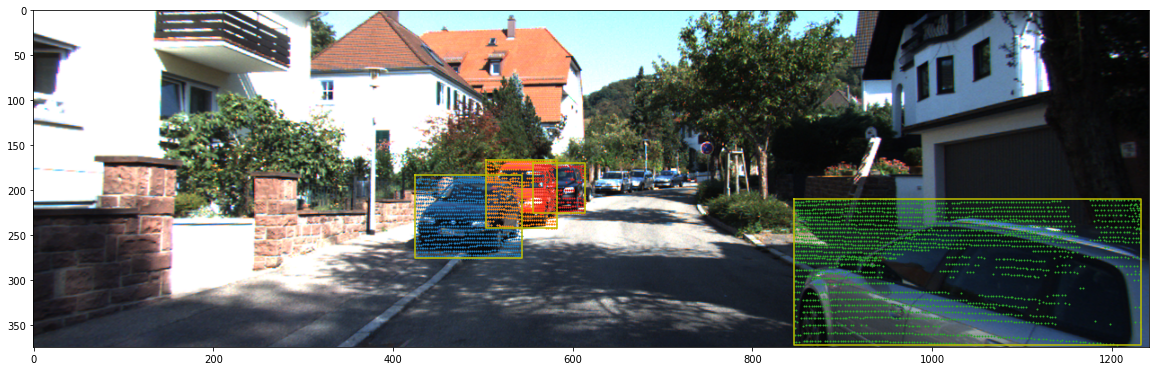

In [547]:
pred = model.predict(item, image, matrix)

In [548]:
pred

Scene(detections=[Detection(xyz=array([-2.38190217,  1.76292198, 14.30755332]), angle=1.6301399118771334, lwh=array([3.77882028, 1.57926769, 1.53939282]), confidence=1.0), Detection(xyz=array([0.        , 0.76281596, 0.        ]), angle=-0.09575414730788512, lwh=array([3.8831164 , 1.6285674 , 1.52563191]), confidence=1.0), Detection(xyz=array([0.        , 0.76281596, 0.        ]), angle=0.5345651451855844, lwh=array([3.8831164 , 1.6285674 , 1.52563191]), confidence=1.0), Detection(xyz=array([0.        , 0.76281596, 0.        ]), angle=-0.037128824772732605, lwh=array([3.8831164 , 1.6285674 , 1.52563191]), confidence=1.0)])

### 2D детектор

В файле ssd.py есть детектор (файл называется ssd, но на самом деле там faster-rcnn), обученный на kitti. У него можно позвать predict на одном изображении. Коробки возвращаются в нормализованных координатах картинки. Класс 1 соответствует машинам, 2 - пешеходам.

In [5]:
from ssd import SSD
import pickle

In [13]:
detector = SSD('tmp')

In [8]:
with open('projection_example.npy') as f:
    data_example = pickle.load(file=f)

In [9]:
image = data_example['image']

In [ ]:
# detector.predict(image)

## Часть 2

Для оценки качества работы 3D детекторов обычно используется average precision. Как измерить precision и recall детектора?

У каждой коробки детектора есть confidence. После того, как мы зафиксировали порог, у нас остается часть детекций.
Давайте теперь посмотрим на сцену сверху: bird's eye view. Забудем про координату z.

Далее мы можем посчитать IoU между всеми коробками ground truth и нашими детекциями.Давайте решим, что если IoU больше 0.7, то мы будем считать, что мы увидели gt коробку - относим эту детекцию к TP. Если gt не нашла пару - False Negative. Если детекция не нашла пару - False Positive.

Ваша задача написать код подсчета метрики average precision построенного детектора.

# Kitti Dataset
[Kitti dev-kit](https://s3.eu-central-1.amazonaws.com/avg-kitti/devkit_object.zip) : 
там можно найти описание данных и как преобразовывать данные между системами координат.

Homework KITTI dataset :https://www.icloud.com/iclouddrive/0bxlXWgCRTVvsWXmd-kcEqKqA#kitti_hw_dataset

In [19]:
import numpy as np
from matplotlib import pyplot as plt 

In [36]:
xyzi = np.fromfile('../kitti_dataset/training/velodyne/000100.bin', dtype=np.float32).reshape(-1, 4)

In [37]:
xyzi

array([[43.889,  0.084,  1.693,  0.   ],
       [43.201,  0.218,  1.67 ,  0.   ],
       [42.397,  0.347,  1.643,  0.   ],
       ...,
       [ 3.696, -1.398, -1.726,  0.31 ],
       [ 3.717, -1.399, -1.736,  0.35 ],
       [ 3.724, -1.389, -1.737,  0.   ]], dtype=float32)

(-50, 50)

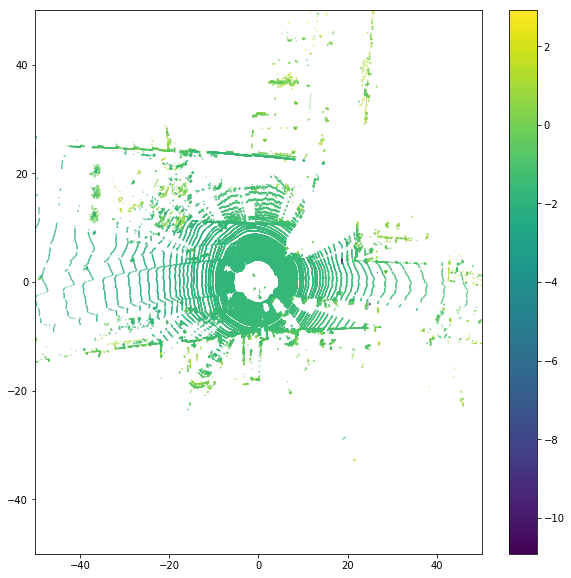

In [43]:
plt.figure(figsize=(10, 10))
plt.scatter(xyzi[:, 0], xyzi[:, 1], c=xyzi[:, 2],  s=0.1)
plt.colorbar()
plt.xlim(-50, 50)
plt.ylim(-50, 50)

In [39]:
import Image

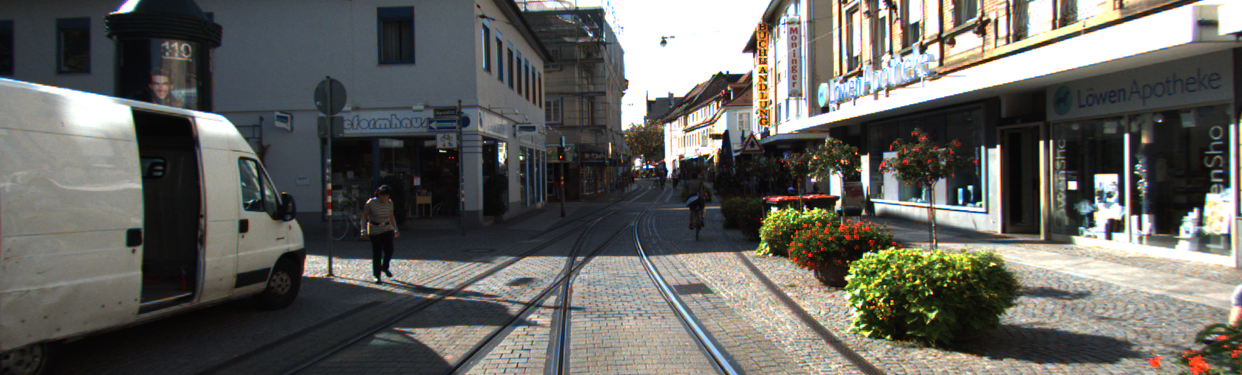

In [40]:
Image.open('../kitti_dataset/training/image_2/000100.png')

In [41]:
with open('../kitti_dataset/training/calib/000100.txt') as f:
    print f.read()

P0: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 0.000000000000e+00 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P1: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.875744000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 0.000000000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 0.000000000000e+00
P2: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 4.485728000000e+01 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.163791000000e-01 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.745884000000e-03
P3: 7.215377000000e+02 0.000000000000e+00 6.095593000000e+02 -3.395242000000e+02 0.000000000000e+00 7.215377000000e+02 1.728540000000e+02 2.199936000000e+00 0.000000000000e+00 0.000000000000e+00 1.000000000000e+00 2.729905000000e-03
R0_rect: 9.999239000000e-01 9.837760000000e-03 -7.445048000000e-03 -9.

In [45]:
with open('../kitti_dataset/training/label_2/000100.txt') as f:
    print f.read()

Van 0.63 0 -0.90 0.00 58.65 320.90 374.00 2.46 2.03 5.35 -5.18 1.69 7.24 -1.51
Cyclist 0.00 0 -1.58 684.31 165.66 710.23 242.31 1.82 0.59 1.89 2.13 1.66 18.06 -1.47
Pedestrian 0.00 0 0.84 359.32 182.26 400.32 285.85 1.57 0.52 0.62 -3.63 1.72 11.35 0.54
Car 0.00 2 -2.46 19.88 179.87 206.64 238.00 1.44 1.62 3.91 -13.04 1.64 18.98 -3.05
DontCare -1 -1 -10 650.19 158.35 666.90 192.77 -1 -1 -1 -1000 -1000 -1000 -10

